# Indian Constitution Q&A System with RAG
This notebook presents a Retrieval-Augmented Generation (RAG) pipeline for querying the Indian Constitution. It uses:
- OpenAI embeddings for semantic search
- ChromaDB for local vector storage
- LangChain to integrate retrieval and generation
- Gradio to provide an interactive Q&A interface

Explore the Constitution by asking about fundamental rights, directive principles, amendments, and other topics.

## Part 1. Installation & Setup

In [ ]:
!pip install langchain langchain-openai langchain-chroma langchain-community
!pip install openai chromadb pypdf gradio python-dotenv
!pip install numpy scikit-learn plotly

#Skip this cell if you already have the required libraries installed!

In [23]:
import os
from dotenv import load_dotenv
import gradio as gr
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go

from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain

In [24]:
MODEL = "gpt-4o-mini"
DB_PATH = "constitution_vectordb"
BOOK_PATH = "indian_constitution.pdf"

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-here')

In [3]:
# TEST if the API key is loaded or not
if os.environ.get('OPENAI_API_KEY') and os.environ['OPENAI_API_KEY'] != 'your-key-here':
    print("API key loaded successfully!")
else:
    print("API key not found.")

API key loaded successfully!


## Part 2. Load the Indian Constitution

In [26]:
loader = PyPDFLoader(BOOK_PATH)
documents = loader.load()
print(f"Loaded {len(documents)} pages")

Loaded 402 pages


In [27]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,
    chunk_overlap=150,
    separators=["\n\n", "\n", ". ", " ", ""]
)
chunks = splitter.split_documents(documents)
print(f"Created {len(chunks)} chunks")

Created 1686 chunks


## Part 3. Create Vector Database with Embeddings

In [28]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

if os.path.exists(DB_PATH):
    Chroma(persist_directory=DB_PATH, embedding_function=embeddings).delete_collection()

vectorstore = Chroma.from_documents(
    documents=chunks,
    embedding=embeddings,
    persist_directory=DB_PATH
)
print(f"Vector database created with {vectorstore._collection.count()} chunks")

Vector database created with 1686 chunks


In [29]:
collection = vectorstore._collection
sample = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
print(f"Each vector has {len(sample):,} dimensions")

Each vector has 1,536 dimensions


In [30]:
data = collection.get(include=['embeddings', 'documents', 'metadatas'])
embeddings_array = np.array(data['embeddings'])
texts = data['documents']
pages = [meta.get('page', 0) for meta in data['metadatas']]

print(f"Retrieved {len(texts)} document chunks for visualization")

Retrieved 1686 document chunks for visualization


### 2D and 3D Visualization

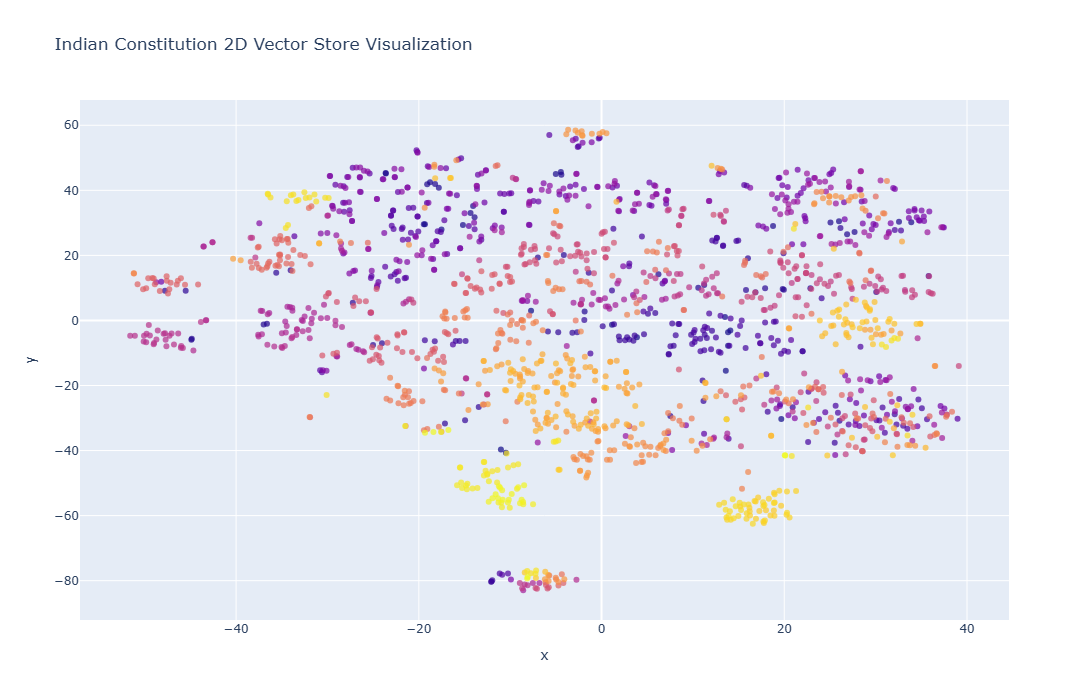

In [31]:
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30)
coords_2d = tsne_2d.fit_transform(embeddings_array)

fig_2d = go.Figure(data=[go.Scatter(
    x=coords_2d[:, 0],
    y=coords_2d[:, 1],
    mode='markers',
    marker=dict(size=6, color=pages, opacity=0.7),
    text=[f"Page {p}<br>{t[:150]}..." for p, t in zip(pages, texts)],
    hoverinfo='text'
)])

fig_2d.update_layout(
    title='Indian Constitution 2D Vector Store Visualization',
    xaxis_title='x',
    yaxis_title='y',
    width=1000,
    height=700
)

fig_2d.show()

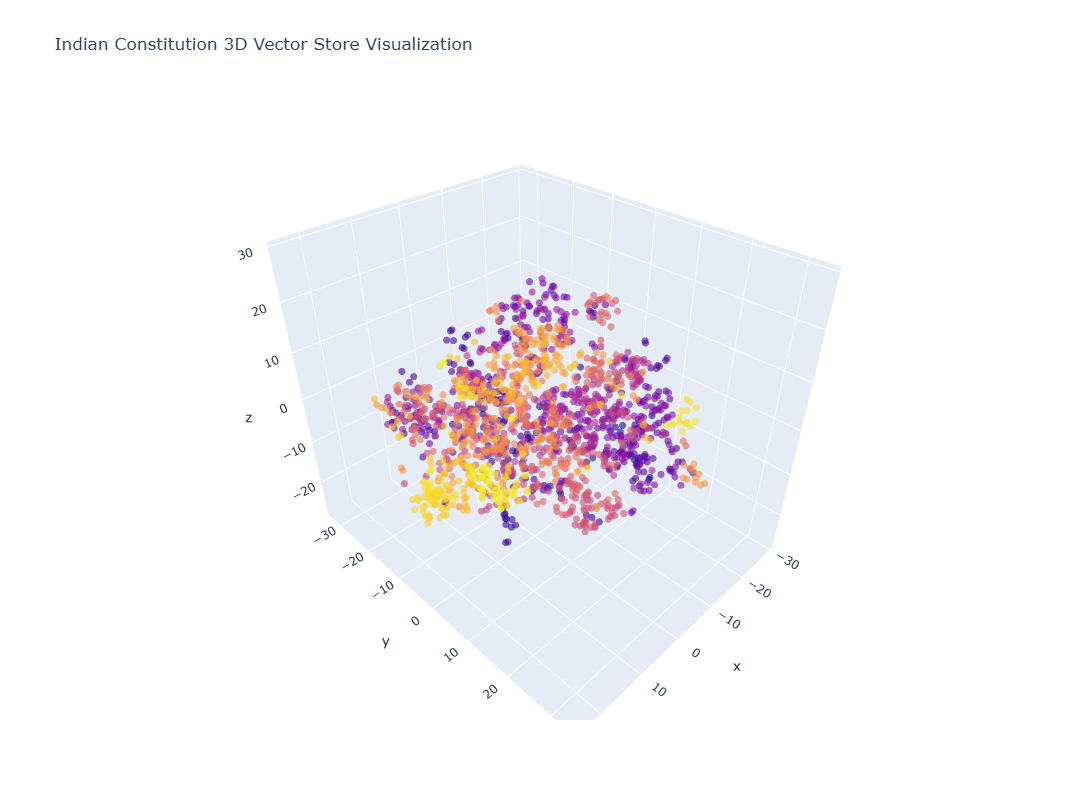

In [32]:
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30)
coords_3d = tsne_3d.fit_transform(embeddings_array)

fig_3d = go.Figure(data=[go.Scatter3d(
    x=coords_3d[:, 0],
    y=coords_3d[:, 1],
    z=coords_3d[:, 2],
    mode='markers',
    marker=dict(size=4, color=pages, opacity=0.6),
    text=[f"Page {p}<br>{t[:150]}..." for p, t in zip(pages, texts)],
    hoverinfo='text'
)])

fig_3d.update_layout(
    title='Indian Constitution 3D Vector Store Visualization',
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='z'
    ),
    width=1000,
    height=800
)

fig_3d.show()

## Part 4. Setup RAG Chain

In [33]:
llm = ChatOpenAI(temperature=0.3, model_name=MODEL)
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True, output_key='answer')
retriever = vectorstore.as_retriever(search_kwargs={"k": 7})

# ConversationalRetrievalChain shows a deprecation warning but still works fine.
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory, return_source_documents=True)

In [34]:
test_query = "What are the fundamental rights guaranteed by the Constitution?"
result = conversation_chain.invoke({"question": test_query})
print(result['answer'])
print(f"Retrieved from {len(result['source_documents'])} sources")

The fundamental rights guaranteed by the Constitution of India include:

1. Right to Equality:
   - Equality before law.
   - Prohibition of discrimination on grounds of religion, race, caste, sex, or place of birth.
   - Equality of opportunity in matters of public employment.
   - Abolition of Untouchability.
   - Abolition of titles.

2. Right to Freedom:
   - Protection of certain rights regarding freedom of speech, etc.
   - Protection in respect of conviction for offences.
   - Protection of life and personal liberty.
   - Right to education.
   - Protection against arrest and detention in certain cases.

3. Right against Exploitation:
   - Prohibition of human trafficking and forced labor.
   - Prohibition of child labor.

4. Right to Freedom of Religion:
   - Freedom of conscience and free profession, practice, and propagation of religion.

5. Cultural and Educational Rights:
   - Protection of the interests of minorities by allowing them to conserve their culture, language, an

## Part 5. Interactive Gradio Interface

In [ ]:
def answer_question(message, chat_history):
    result = conversation_chain.invoke({"question": message})
    answer = result['answer']

    sources = result.get('source_documents', [])
    if sources:
        answer += f"\n\n(Retrieved from {len(sources)} sources)"

    chat_history = chat_history or []
    chat_history.append({"role": "user", "content": message})
    chat_history.append({"role": "assistant", "content": answer})
    return chat_history

with gr.Blocks(title="Indian Constitution Q&A") as ui:
    gr.Markdown("# Indian Constitution Q&A System\nAsk questions about articles, amendments, fundamental rights, and more.")
    with gr.Row():
        with gr.Column(scale=4):
            chatbot = gr.Chatbot(height=500, type="messages")
            msg = gr.Textbox(placeholder="Ask a question about the Constitution...")
        with gr.Column(scale=1):
            gr.Markdown("### Example Questions:")
            gr.Markdown("""
            - What are fundamental rights?
            - Explain Article 370
            - What is the Right to Education?
            - List the Directive Principles
            - What are the amendment procedures?
            - Explain the federal structure
            """)
    msg.submit(answer_question, [msg, chatbot], [chatbot])
    
ui.launch(share=False, inbrowser=True)